In [1]:
!pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

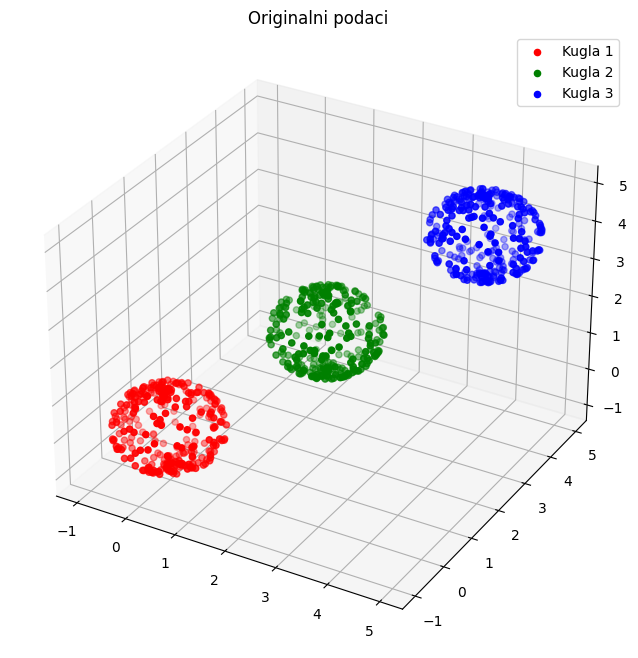

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def generate_spheres(n):
    phi = np.random.uniform(0, 2 * np.pi, n)  # Azimutalni kutovi
    theta = np.random.uniform(0, np.pi, n)    # Polarni kutovi
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.vstack((x, y, z)).T             # Vraća n x 3 matricu

n = 300

K1 = generate_spheres(n)
K2 = generate_spheres(n) + 2
K3 = generate_spheres(n) + 4


data = np.vstack((K1, K2, K3))
noise = np.random.uniform(0, 1, (data.shape[0], 7))
data_noisy = np.hstack((data, noise))


fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, projection='3d')


ax1.scatter(K1[:, 0], K1[:, 1], K1[:, 2], color='red', marker='o', label='Kugla 1')
ax1.scatter(K2[:, 0], K2[:, 1], K2[:, 2], color='green', marker='o', label='Kugla 2')
ax1.scatter(K3[:, 0], K3[:, 1], K3[:, 2], color='blue', marker='o', label='Kugla 3')


ax1.legend()
ax1.set_title('Originalni podaci')

plt.show()


Epoch 10/50, Loss: 1.4959
Epoch 20/50, Loss: 1.2371
Epoch 30/50, Loss: 1.2349
Epoch 40/50, Loss: 1.2090
Epoch 50/50, Loss: 1.1907


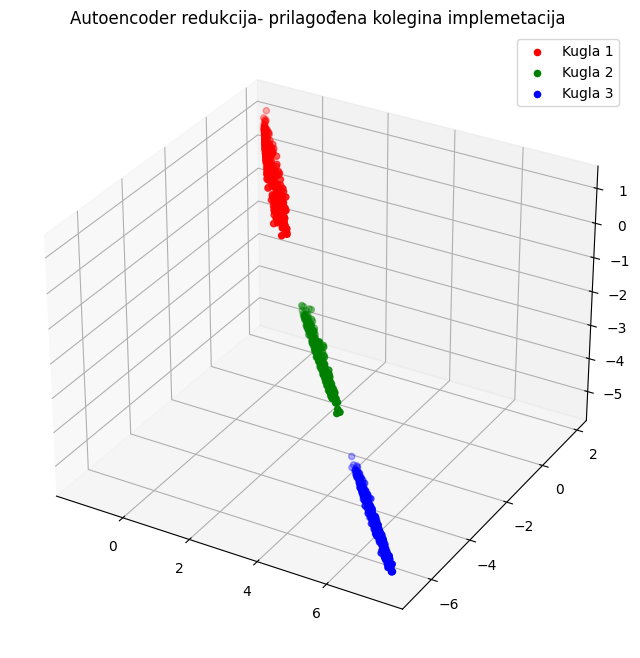

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 6),
            nn.ReLU(),
            nn.Linear(6, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.ReLU(),
            nn.Linear(6, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)


data_tensor = torch.tensor(data_noisy, dtype=torch.float32)

n_epochs = 50
for epoch in range(n_epochs):
    autoencoder.train()
    outputs = autoencoder(data_tensor)
    loss = criterion(outputs, data_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')


def extract_features(autoencoder, data):
    autoencoder.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data, dtype=torch.float32)
        encoded_data = autoencoder.encoder(data_tensor).numpy()
    return encoded_data

data_reduced = extract_features(autoencoder, data_noisy)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data_reduced[:n, 0], data_reduced[:n, 1], data_reduced[:n, 2], color='red', marker='o', label='Kugla 1')
ax.scatter(data_reduced[n:2*n, 0], data_reduced[n:2*n, 1], data_reduced[n:2*n, 2], color='green', marker='o', label='Kugla 2')
ax.scatter(data_reduced[2*n:, 0], data_reduced[2*n:, 1], data_reduced[2*n:, 2], color='blue', marker='o', label='Kugla 3')

ax.legend()
ax.set_title('Autoencoder redukcija- prilagođena kolegina implemetacija')
plt.show()


In [8]:
#Autoencoder redukcija dimenzija

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_layer = Input(shape=(data_noisy.shape[1],))
encoded = Dense(5, activation='relu')(input_layer) # kodirni dio autoencodera - ulazne podatke komprimiramo u 5-dimenzionalni prostor pomoću Dense sloja s relu aktivacijom. Zatim ih dodatno komprimiramo u 3-dimenzionalni prostor, što je naš cilj (izlazna dimenzionalnost).
encoded = Dense(3, activation='relu')(encoded)

decoded = Dense(5, activation='relu')(encoded)
decoded = Dense(data_noisy.shape[1], activation='sigmoid')(decoded) #Dekodiranje: Ovaj dio mreže pokušava rekonstruirati originalne podatke iz 3-dimenzionalnog kodiranog prostora. Prvo, podaci se dekodiraju natrag u 5 dimenzija pomoću
#Dense sloja s relu aktivacijom. Na kraju, dekodiramo ih natrag na originalni broj dimenzija (jednak data_noisy.shape[1]) pomoću Dense sloja s sigmoid aktivacijom.
#Aktivacija sigmoid koristi se jer je zadnji sloj mreže koji vraća izlaz unutar raspona [0, 1].

autoencoder = Model(input_layer, decoded) # kreiramo model koji korsiti cijelu mrezu
encoder = Model(input_layer, encoded) #Kreiramo također i poseban model samo za kodiranje, što nam omogućava da dobijemo kodirane podatke (tj. podatke s reduciranim dimenzijama) direktno iz mreže.

autoencoder.compile(optimizer='adam', loss='mse') #adam optimizator,za treniranje neuronskih mreža, te koristimo mse (mean squared error) kao funkciju gubitka
autoencoder.fit(data_noisy, data_noisy, epochs=1000, batch_size=256, shuffle=True, verbose=0) #treniranje autonecodera, broj epoha =1000,  podaci se dijele u grupe po 256 uzoraka

data_autoencoded = encoder.predict(data_noisy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


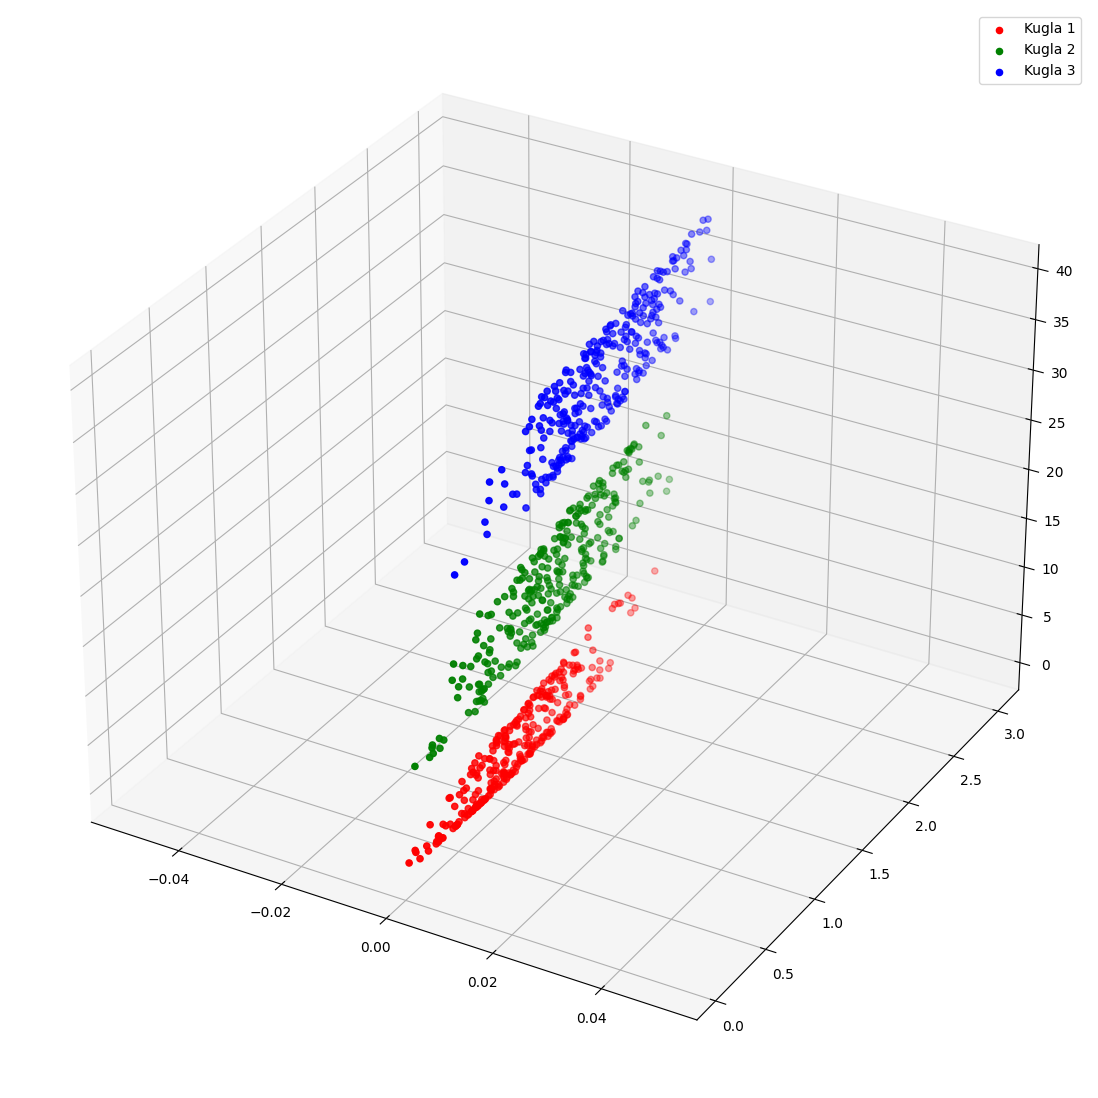

In [9]:

fig = plt.figure(figsize=(28, 14))
ax1 = fig.add_subplot(111, projection='3d')


n = 300
ax1.scatter(data_autoencoded[:n, 0], data_autoencoded[:n, 1], data_autoencoded[:n, 2], color='red', marker='o', label='Kugla 1')
ax1.scatter(data_autoencoded[n:2*n, 0], data_autoencoded[n:2*n, 1], data_autoencoded[n:2*n, 2], color='green', marker='o', label='Kugla 2')
ax1.scatter(data_autoencoded[2*n:, 0], data_autoencoded[2*n:, 1], data_autoencoded[2*n:, 2], color='blue', marker='o', label='Kugla 3')


ax1.legend()
plt.show()



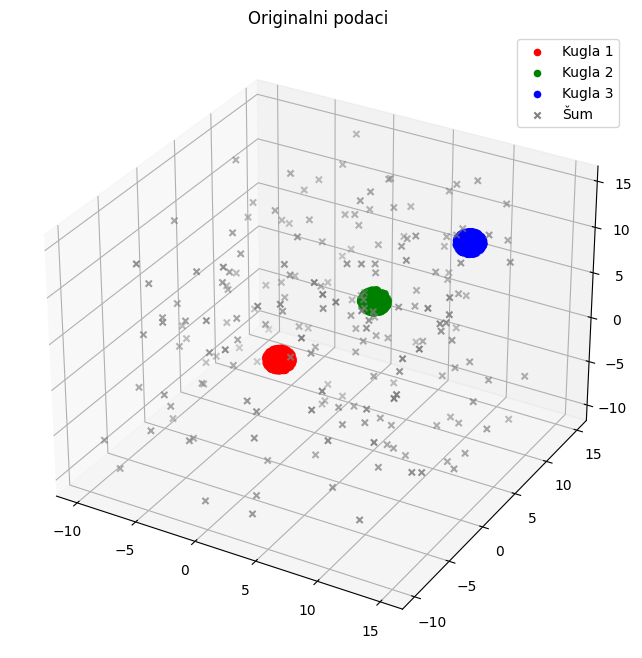

In [10]:
def generate_spheres(n):
    phi = np.random.uniform(0, 2 * np.pi, n)  # Azimutalni kutovi
    theta = np.random.uniform(0, np.pi, n)    # Polarni kutovi
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.vstack((x, y, z)).T             # Vraća n x 3 matricu

def add_noise(data, noise_points):
    noise = np.random.uniform(-10, 15, (noise_points, data.shape[1]))
    return np.vstack((data, noise))

def permute_coordinates(data):
    permuted_data = np.copy(data)
    np.random.shuffle(permuted_data.T)
    return permuted_data

n = 300


K1 = generate_spheres(n)
K2 = generate_spheres(n) + 5
K3 = generate_spheres(n) + 10


data = np.vstack((K1, K2, K3))
data_with_noise = add_noise(data, 200)


noise = np.random.uniform(0, 1, (data_with_noise.shape[0], 7))
data_noisy = np.hstack((data_with_noise, noise))

data_permuted = permute_coordinates(data_noisy)


fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, projection='3d')


ax1.scatter(K1[:, 0], K1[:, 1], K1[:, 2], color='red', marker='o', label='Kugla 1')
ax1.scatter(K2[:, 0], K2[:, 1], K2[:, 2], color='green', marker='o', label='Kugla 2')
ax1.scatter(K3[:, 0], K3[:, 1], K3[:, 2], color='blue', marker='o', label='Kugla 3')
ax1.scatter(data_with_noise[n*3:, 0], data_with_noise[n*3:, 1], data_with_noise[n*3:, 2], color='gray', marker='x', label='Šum')


ax1.legend()
ax1.set_title('Originalni podaci')
plt.show()




Epoch 10/50, Loss: 11.8044
Epoch 20/50, Loss: 11.2996
Epoch 30/50, Loss: 11.0023
Epoch 40/50, Loss: 10.9653
Epoch 50/50, Loss: 10.9478


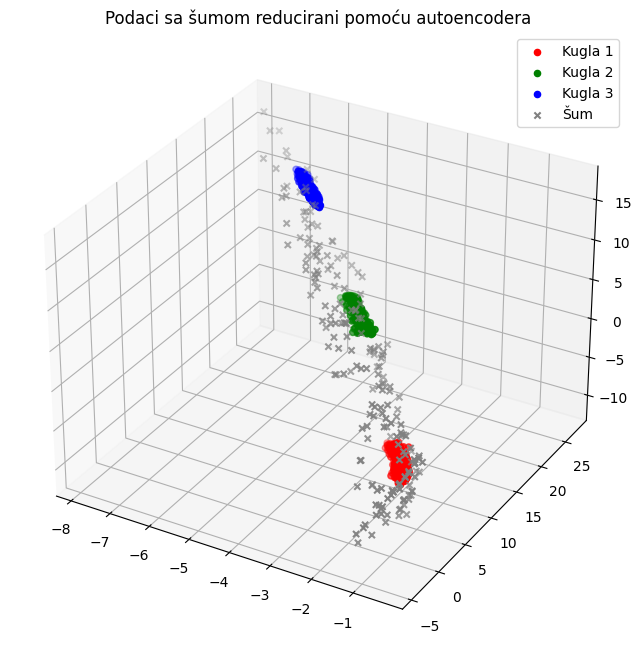

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 6),
            nn.ReLU(),
            nn.Linear(6, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.ReLU(),
            nn.Linear(6, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)


data_tensor = torch.tensor(data_permuted, dtype=torch.float32)

n_epochs = 50
for epoch in range(n_epochs):
    autoencoder.train()
    outputs = autoencoder(data_tensor)
    loss = criterion(outputs, data_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')

def extract_features(autoencoder, data):
    autoencoder.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data, dtype=torch.float32)
        encoded_data = autoencoder.encoder(data_tensor).numpy()
    return encoded_data


data_reduced = extract_features(autoencoder, data_permuted)

labels = np.concatenate([
    np.zeros(300),
    np.ones(300),
    np.full(300, 2),
    np.full(200, 3)
])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_reduced[labels == 0, 0], data_reduced[labels == 0, 1], data_reduced[labels == 0, 2], color='red', marker='o', label='Kugla 1')
ax.scatter(data_reduced[labels == 1, 0], data_reduced[labels == 1, 1], data_reduced[labels == 1, 2], color='green', marker='o', label='Kugla 2')
ax.scatter(data_reduced[labels == 2, 0], data_reduced[labels == 2, 1], data_reduced[labels == 2, 2], color='blue', marker='o', label='Kugla 3')
ax.scatter(data_reduced[labels == 3, 0], data_reduced[labels == 3, 1], data_reduced[labels == 3, 2], color='gray', marker='x', label='Šum')


ax.legend()
ax.set_title('Podaci sa šumom reducirani pomoću autoencodera')

plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


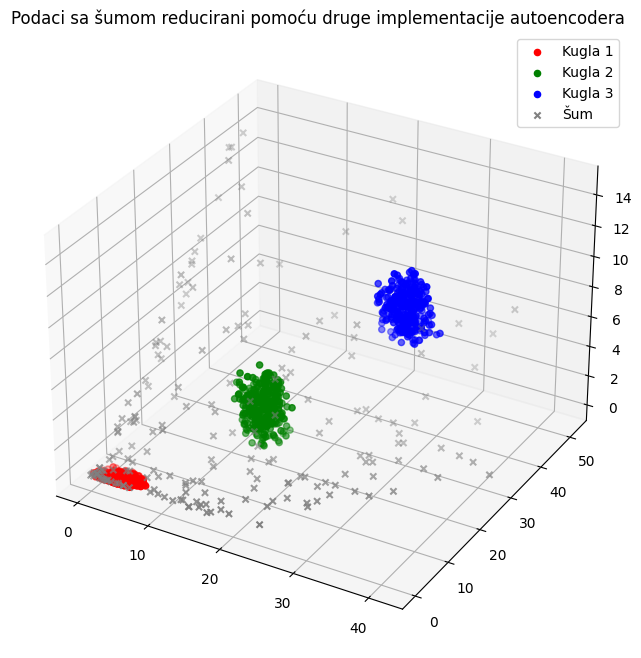

In [12]:
input_layer = Input(shape=(data_permuted.shape[1],))
encoded = Dense(5, activation='relu')(input_layer)
encoded = Dense(3, activation='relu')(encoded)

decoded = Dense(5, activation='relu')(encoded)
decoded = Dense(data_permuted.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_permuted, data_permuted, epochs=1000, batch_size=256, shuffle=True, verbose=0)


data_autoencoded = encoder.predict(data_permuted)


labels = np.concatenate([
    np.zeros(300),
    np.ones(300),
    np.full(300, 2),
    np.full(200, 3)
])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data_autoencoded[labels == 0, 0], data_autoencoded[labels == 0, 1], data_autoencoded[labels == 0, 2], color='red', marker='o', label='Kugla 1')
ax.scatter(data_autoencoded[labels == 1, 0], data_autoencoded[labels == 1, 1], data_autoencoded[labels == 1, 2], color='green', marker='o', label='Kugla 2')
ax.scatter(data_autoencoded[labels == 2, 0], data_autoencoded[labels == 2, 1], data_autoencoded[labels == 2, 2], color='blue', marker='o', label='Kugla 3')
ax.scatter(data_autoencoded[labels == 3, 0], data_autoencoded[labels == 3, 1], data_autoencoded[labels == 3, 2], color='gray', marker='x', label='Šum')


ax.legend()
ax.set_title('Podaci sa šumom reducirani pomoću druge implementacije autoencodera')

plt.show()
